# Поиск вырубок: разведка

Цель всех действий, которые производятся ниже -- понять, как выглядят вырубки на снимках, и какими призаками можно пользоваться, чтобы эти вырубки "поймать".

Пока я вижу следующие потенциально рабочие подходы:
 
1. Анализ временной динамики -- вырубка это резкое изменение отражательной способности. Причем изменение не любое, а определенного вида. Такой подход подразумевает, что мы можем обрабатывать каждый пиксель по одтельности, строить соответсвующие пикселю временные ряды изменений и искать на них "типичные" для вырубок изменения. Подход, по видимости, требует качественной фильтрации данных от мусора (облаков, теней) и уравнивания (стандартизации) снимков, сделанных в разное время (разное время года, разная освещенность, разные атмосферные условия). Представляется, что подобная предобработка данных будет довольно трудоемкой. *Текущий подход, который использует метрики, по сути является вариацией этого метода: метрики как раз и дают относительно устойчивые характеристики территории, которые сглаживают различия разновременных снимков.*
2. Анализ данных в пространственной области. Тут имеется в виду, что на снимках высокого разрешнения вырубки могут иметь характерный вид: центральная часть и идущие к ней волоки. Если это действительно так, то можно попробовать определять вырубки по подобным "отпечаткам". Это позволит избежать сложностей со стандартизацией разновременных снимков. С другой стороны, такой подход, вероятно, даст большое число ложных срабатываний на участках, которые похожи на вырубки (пролысины?, перекрестки дорог?). Тем не менее, мне представляется, что этот подход проще первого в реализации и, хотя первый путь потенциально более перспективен, я думаю, что нужно начать с поиска в пространственной области (легче реализовать => быстрее получим результаты => в случае удачи сэкономим время и усилия, а в случае неудачи потратимся не очень значительно).

Также возможны гибридные варианты, когда вырубка ищется и в пространственной, и во временной области.

Поэтому первая часть блокнота содержит раздел по визуализации имеющихся вырубок и визуального выделения признаков вырубок.

# Комментарий ИГ
1. Пока задача стоит разобратся с одним временем года (декабрь-март) и это с одной стороны проще - поскольку, нет фенологических изменений (за редким исключением), с другой стороны это сужает (возможно, на самом деле может быть и нет) возможности использования всяких индексов (NDVI и пр.). По первому подходу я вижу следующую последовательность действий (если это можно реализовать на данной платформе):

А) Создание базового безоблочного композита для зимы 2015 г. (если не получится набрать достаточное кол-во данных, добавить 2014). Здесь нам важно получить максимальное количество безоблачных пикселей и полное покрытие территории. Время отдельной сцены не важно.
Получение снимков и перевод в TOA - реализовано

QA анализ и нормализация - удаление облаков и теней на первом этапе можно использовать BQA слой, но думаю, что качество не будет нас устраивать, можно попробовать добавить буфера (элементы best pixels selection -http://www.tandfonline.com/doi/full/10.1080/07038992.2014.945827). 

Другие варианты - добавить FMASK (если это можно сделать на этой платформе) или сделать отдельный модуль для классификации на облака/воду/тени и т.д. Я могу сделать нужный слой треннингов для терриитории.

Про нормализацию: сначала, можно попробовать сделать вообще без нее (главное без облаков) и посмотреть что получится, но если возникнет необходимость добавлять данные (L7,S2), то понадобится. 

Если следовать "правильному" пути, то нужно сделать два модуля:

1) пересчитывает значения в каналах в зависимости от положения от центра снимка (можно просто взять коэф. регрессии из Петиной статьи, например, поскольку этот параметр вряд ли должен менятся в зав. от сезона) 
2) Нормализация по МОДИС (MOD43 или MOD09) -отбор "лучших" пикселей и пересчет (в среднее или медианное) значение за этот же период (2015) - построение ур. регрессии (MOD ~ LANDSAT) -коэф. использовать при обработке.

Создание композита.

Б) Обработка актуальных данных
Получение снимков и перевод в TOA - реализовано

QA анализ и нормализация - здесь пока можно ограничится только удалением облаков, поскольку изменения (рубки) в большинстве случаев сильно перекрывают всю прочую вариацию

Классификация

2. По второму подходу комментариев у меня пока нет

Планируется использовать -какие то текстурные характеристики брать с VHR и применять к Landsat -у?


## Подключение необходимых функций

Импортируем необходимые библиотеки и функции:

In [1]:
import numpy as np

import utilites
reload(utilites)

from utilites import (
    get_grassdata_path,
    get_location_name,
    get_location_path,
    get_wms_link,
    rm_grass_lock,
)

In [2]:
import matplotlib
# Force matplotlib to not use any Xwindows backend.
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [3]:
import grasslib
reload(grasslib)
from grasslib import GRASS


grs = GRASS(gisbase='/usr/lib/grass70', 
            dbase=get_grassdata_path(), 
            location=get_location_name()
)

Для того, чтобы не засорять PERMANENT вспомогательными и/или временными данными, переключимся в отдельный MAPSET (под названием exploration). Если такого набора нет, то он будет создан (флаг -c):

In [4]:
grs.grass.run_command('g.mapset', mapset='exploration', flags='c')
print grs.grass.read_command('g.mapset', flags='p')

exploration



## Как выглядят вырубки?

### Рубки в PlanetLabs

#### Вырубки, появившиеся зимой 2015-2016.

(В таблицах ниже ссылки в заголовках ведут на интерактивную карту для более детального рассмотрения.)

* Вырубка, появившаяся зимой в промежутке между 8-го января и 3-го февраля 2016-го года. Вырубка едва заметна. Найти ее можно по более светлому пятну по сравнению с окружающим его участком. Сам участок помимо того, что поменял цвет, стал более "шершавый" на вид. Размер вырубки порядка 100 метров в диаметре. Элементы текстуры представляют собой округлые пятна, яркость которых увеличивается к середине пятна и спадает к его краям. Размер элемента текстуры обычно около 20 метров.

[До вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.2648493647575&lat=47.61579915637495&zoom=17&styles=16,29) | [После вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.2648493647575&lat=47.61579915637495&zoom=17&styles=16,23)
--------|---------
<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=519572,5273372,520259,5273908&WIDTH=600&HEIGHT=600&LAYERS=20160108_011229_0c53_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=519572,5273372,520259,5273908&WIDTH=600&HEIGHT=600&LAYERS=20160302_225400_0c68_visual.composite@planet">



* Вырубка конца декабря 2015 года, размер приблизительно 50 метров по диагонали. Текстурные различия на снимках найти сложно, точнее на снимке от 7-го декабря также видна некоторая неоднородность структуры на фоне серой подстилки, но от фона она мало отличается. (Возможно, ошибка в данных и вырубка случилась ранее декабря?). Вот еще ссылки на эту рубку, приведенные здесь для того, чтобы можно было оценить вариации условий съемки: [29.02.2016](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24662911891937&lat=47.558087982676&zoom=18&styles=16,29), [03.03.2016](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24662911891937&lat=47.558087982676&zoom=18&styles=16,23).

[До вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24662911891937&lat=47.558087982676&zoom=18&styles=16,41) | [После вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24662911891937&lat=47.558087982676&zoom=18&styles=16,35)
--------|---------
<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=518184,5266924,518871,5267460&WIDTH=600&HEIGHT=600&LAYERS=20151207_013046_090c_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=518184,5266924,518871,5267460&WIDTH=600&HEIGHT=600&LAYERS=20151230_042202_0c07_visual.composite@planet">



* Вырубка конца декабря 2016 г. Ниже приводится снимок, сделанный до появления вырубки и два снимка, сделанные позднее. Каких-либо заметных отличий вырубки от окружающего фона не заметно (на месте вырубки присутствует "шершавое" пятно, но оно также присутствует и на снимке, сделанном до вырубки). Ошибка в описании данных? Размер текстурного элемента также около 20 метров.

[До вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24963855743408&lat=47.5705180572663&zoom=17&styles=16,29) | [После вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24963855743408&lat=47.5705180572663&zoom=17&styles=16,25) |  [После вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.24963855743408&lat=47.5705180572663&zoom=17&styles=16,23)
--------|---------|----
<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=518347,5268331,519002,5268867&WIDTH=600&HEIGHT=600&LAYERS=20160108_011229_0c53_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=518347,5268331,519002,5268867&WIDTH=600&HEIGHT=600&LAYERS=20160229_040923_0c72_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=518347,5268331,519002,5268867&WIDTH=600&HEIGHT=600&LAYERS=20160302_225400_0c68_visual.composite@planet">

* Вырубка, помеченная как произошедшая в конце декабря. Но, по всей видимости, она случилась в январе ([ссылка](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.27785003185272&lat=47.58894055913254&zoom=17&styles=16,29) на январский снимок, на котором присутствует объект, похожий на вырубку). Текстурные элементы также выражены слабо, их размер составляет около 20 метров.

[До вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.27785003185272&lat=47.58894055913254&zoom=17&styles=16,37) | [После вырубки](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.27785003185272&lat=47.58894055913254&zoom=17&styles=16,23)
--------|---------
<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=520568,5270366,521223,5270901&WIDTH=600&HEIGHT=600&LAYERS=20151219_050318_0c53_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=520568,5270366,521223,5270901&WIDTH=600&HEIGHT=600&LAYERS=20160229_040923_0c72_visual.composite@planet">

#### Вырубки, появившиеся до конца осени 2015 г.

Ниже приводятся примеры вырубок, для которых нет данных PlanetLabs "до вырубки -- после вырубки", поэтому для них нельзя посмотреть направление изменений. Однако для этих примеров можно посмотреть, как выглядит вырубка на зимних снимках (почти) годом позднее. Поскольку вегетации в зимний период нет, то (ожидается), что на снимках представлено одно и то же состояние территории. Все различия, видимые на снимках, -- следствия различных условий съемки и состояния атмосферы. Поэтому эти примеры позволят оценить "внешнюю" вариативность данных, не связанную с реальными изменениями на местности.

* Вырубка, появившаяся в марте 2015 года. Ниже идут три зимних снимка одного и того же участка. Вырубка представлет собой относительно однородное пятно белого цвета.

[30.12.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.36266309924733&lat=47.68150010806235&zoom=17&styles=16,31) | [19.12.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.36266309924733&lat=47.68150010806235&zoom=17&styles=16,37) | [11.11.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.36266309924733&lat=47.68150010806235&zoom=17&styles=16,43)
--------|---------|----
<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=526864,5280722,527551,5281257&WIDTH=400&HEIGHT=400&LAYERS=20151230_043745_0c47_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=526864,5280722,527551,5281257&WIDTH=400&HEIGHT=400&LAYERS=20151219_050318_0c53_visual.composite@planet">|<img src="http://176.9.38.120/cruncher_wms/wms/planet/?SERVICE=WMS&REQUEST=GetMap&BBOX=526864,5280722,527551,5281257&WIDTH=400&HEIGHT=400&LAYERS=20151111_235840_0c64_visual.composite@planet">

* Аналогичный случай, участок на километр юго-восточнее: [30.12.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.3673768043518&lat=47.675581447251545&zoom=17&styles=16,31), [19.12.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.3673768043518&lat=47.675581447251545&zoom=17&styles=16,37), [11.11.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.3673768043518&lat=47.675581447251545&zoom=17&styles=16,43). Вырубка -- однородное пятно белого цвета.

* Снимки одной и той же вырубки, сделанные в разные дни. Почти на всех снимках вырубки видна дорога (волок?), проходящая в центральной части вырубки, а также лесная дорога:
 (А) Самый поздний снимок из имеющихся [02.03.2016-1](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,21), вырубка на нем выглядит как белое пятно на темном фоне. По текстуре она очень напоминает облако. Снимок сделанный в тот же день, но другой path/row [02.03.2016-2](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,23), каких-то видимых различий между ними нет, не смотря на то, что вырубка на снимке "а" находится на самом краю сцены. (Б) Снимок имеет более четко выраженную текстуру фона идующу в северо-северо-восточном направлении: [29.02.2016](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,25), по всей вероятности тот факт, что текстура видна не на всех снимках, каким-то образом связана с выпавшим (выпадающим?) снегом. (В) Очень похожая текстура присутствует на снимке [08.01.2016](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,29), но она расположена в северо-серверо-восточном направлении; эта разница в направлении текстур (ср. снимок Б) говорит об их временной природе (осадки в момент их перемещения или освещение). Мне представляется маловероятным, что языки снега, подобные видимым на снимках, связаны с его переносом (выпадение осадков или поземка), поскольку выпадение снега должно быть связано с облачностью, а поземка маловероятна(?) в лесу. (Г) Далее идут три снимка, сделанные в один день но разными path/row: [30.12.2016-1](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,31), [30.12.2016-2](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,33), [30.12.2016-3](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,35), на всех трех присутствует та же вытяннутая в одном и том же направлении текстура. Судя по теням от горных цепей снимки сделаны приблизительно в одно и то же время, поэтому они не позволяют проверить связано ли направление текстур с освещенностью.  (Д) [19.12.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,37), (Е) Снимки [07.12.2015-1](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,39), [07.12.2015-2](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,41) мало что добавляют уже известному, но они сделаны в период, когда снега еще мало, поэтому на них вырубка видна более четко. (Ж) Снимок [11.11.2015](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,43) является довольно мутным, поэтому несет не очень много информации. (З) Снимки [06.11.2015-1](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,45), [06.11.2015-2](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.310025872859&lat=47.58763618807765&zoom=17&styles=16,47) интересны тем, что они сделаны до того, как на территории устоялся снежный покров. Эти снимки показывают, что текстура вырубки практически не видна на фоне леса, также лесные дороги, четко прослеживаемые на зимних снимках на основной части протяжения скрыты пологом леса. В частности, на этих снимках не видна дорога (волок?), пересекающая вырубку, заметную на зимних снимках.

### Общий вывод по PlanetLabs

Вырубки на зимних снимках выглядят очень похожими на облака: имеют ту же "шершавую" структуру и белый цвет. Они могут отличаться по текстуре от фона, но не всегда. Зачастую вырубки теряются на фоне других белых объектов, но часть из таких фоновых объектов можно отсеять по их линейной структуре: они занимают большие площади и их текстуры имеют характерные вытянутости вдоль одной из осей. Текстура вырубки (если она присутствует) представляет собой округлые пятна, яркость которых увеличивается к середине пятна и спадает к его краям. Размер элемента текстуры обычно около 20 метров, хотя он может варьироваться даже в пределах одной вырубки (от 15 и до 30, реже 40 метров).

## Применение текстурных признаков для поиска вырубок

Оценим применимость текстурных признаков для поиска вырубок, при этом будем анализировать две группы признаков. Первая группа будет содержать простые признаки типа "среднее значение", "минимум" и т.п., рассчитанные в скользящем окне. Вторая группа признаков -- это классические текстурные характеристики, введенные в работе Haralick, R.M., K. Shanmugam, and I. Dinstein (1973). Textural features for image classification. IEEE Transactions on Systems, Man, and Cybernetics, SMC-3(6):610-621.

### Описание текстурных признаков

#### Схема рассчета текстурных признаков по Харалику

Текстурные признаки согласно Харалику рассчитываются для одноканального растра по следующей схеме:
 * Задаются параметры алгоритма: размер скользящего окна, и вектор сдвига для расчета статистики. Вектор сдвига определяется относительно текущей ячейки (пикселя) скользящего окна и представляет собой число ячеек и угол на которые нужно сместиться от текущей ячейки (например, сдвиг на 90 градусов и три пикесля "помечает" ячейку, находящуюся тремя пикселями севернее относительно текущего пикселя).
 * Далее строится гистограмма совместного распределения яркости пар пикселей $P$, находящихся на заданный вектор сдвига (расстоянии и направлении) друг от друга. Эта гистограмма представляет собой таблицу, число строк и столбцов таблицы равно числу градаций серого в анализируемом растре. Изначально таблица инициализируется нулями. Затем в текущем окне пробегаются пары пикселей, находящиеся друг от друга на расстоянни и направлении с указанным сдвигом, и заполняется таблица: если начальный пиксель имеет значение яркости I, а парный ему (соответствующий сдвигу) пиксель -- яркость J, то значение в таблице на I-й строке в J-м столбце увеличивается на единицу. Таким образом после завершения процедуры в каждой ячейки таблицы будет хранится число пар пикселей, разделенных сдвигом, с соответсвующими яркостями (гистограмма совместного распределения). Математически процедура записывается следущим образом (например, для направления в 0 градусов): $$P(i,j,d,0) = \#\Big\{\big((k,l), (m,n)\big) \in (L_y\times L_x)\times (L_y\times L_x): k-m=0, |l-n|=d, I(k,l)=i, I(m,n)=j \Big\},$$ где знаком $\#$ обозначено число пикселей, функция $I(k,l)$ возвращает яркость пикселя с координатами $(k,l)$, а $(L_y\times L_x)$ -- окно, в котором происходит анализ.
 * По полученной гистограмме рассчитываются текстурные признаки, формулы расчета которых представлены ниже.

#### Формулы расчета и качественное описание признаков

Текстурные признаки по Харалику представляют собой статистики, построенные по гистограмме совместного распределения яркостей пикселей. Эти признаки сильно коррелированы между собой. Для большей наглядности и понимания на качественном уровне того, как ведут себя признаки, удобно представлять себе два крайних случая -- почти полностью однородное изображение (все пиксели примерно одинаковой яркости) и полностью случайное, когда яркость всех пикселей распределена по равномерному закону, не зависит от положения пикселя.

Для первого случая матрица $P$ будет представлять собой матрицу, в которой один элемент содержит очень большое значение, а остальные элементы близки к нулю. Для второго случая матрица $P$ будет состоять из примерно равных значений.

##### Обозначения

 * $N_g$ -- число градаций серого в растре.
 * $P$ -- гистограмма совместного распределения яркости пар пикселей, находящихся на заданном расстоянии и направлении друг от друга.
 * $R$ -- общее число пар пикселей, находящихся на заданном расстоянии и направлении друг от друга (зависит от размера окна, расстояния и направления сдвига).
 * $p(i,j)$ -- ячейка $(i,j)$ нормированной гистограммы $P$, (т.е. $p(i,j) = P(i,j)/R$).
 * $p_x(i)$ -- сумма значений в i-й строке матрицы $p(i,j)$, т.е. $p_x(i) = \sum_{j=1}^{N_g}p(i,j)$.
 * $p_y(j) = \sum_{i=1}^{N_g}p(i,j)$.
 * $p_{x+y}(k) = \sum_{i=1}^{N_g}\sum_{j=1}^{N_g}p(i,j) \quad \Big| i+j = k$ (здесь суммирование идет только по тем парам i, j, которые в сумме дают k: $i+j=k$, $k=2,3,\dots, 2N_g$).
 * $p_{x-y}(k) = \sum_{i=1}^{N_g}\sum_{j=1}^{N_g}p(i,j) \quad \Big| |i-j| = k$, $k=0,1,\dots, N_g-1$. Аналогично, суммирование идет только по тем парам, модуль разности которых равен $k$.
 
 
 Для сокращения записи ниже также применяются следующие обозначения: $\sum_i = \sum_{i=1}^{N_g}$,  $\sum_j = \sum_{j=1}^{N_g}$

##### Признаки

**ToDO:** прописать, как какой признак характеризует типичные (однородные или случайные) текстуры.

*Заметим, что $R$ будет расти как квадрат от размера стороны скользящего окна. $N_g$ -- число градаций серого в растре, обычно оно не велико (255 уже много).*

Angular Second Moment:
$$f_1 = \sum_i \sum_j \big(p(i,j)\big)^2.$$

Для случая однородной текстуры значение $f_1$ будет приближаться к единице, для случайной текстуры -- к $1/R$, при больших размерах окна -- к нулю.

Contrast:
$$f_2 = \sum_{n=0}^{N_g-1}n^2 p_{x-y}(n).$$

Для случая однородной текстуры значение $f_2$ будет приближаться к нулю, для случайной текстуры -- увеличиваться с ростом размера окна *(с последним не уверен на 100%, нужно еще посчитать)*.

Correlation:
$$f_3 = \frac{\sum_{i}\sum_{j} (ij)p(i,j) - \mu_x \mu_y}{\sigma_x\sigma_y},$$
где $\mu_x$ и $\mu_y$ -- среднее для $p_x$ и $p_y$ соотвественно, а $\sigma_x$ и $\sigma_y$ -- их стандартные отклонения.

Для однородной текстуры $f_3$ будет очень велико (для идеально однородной -- получится деление на ноль), для случайной текстуры будет около нуля.

Sum of Squares:
$$f_4 = \sum_{i}\sum_{j} (i-\mu)^2 p(i,j).$$

Inverse Difference Moment:
$$f_5 = \sum_{i}\sum_{j} \frac{1}{1+(i-j)^2} p(i,j).$$

Sum Average:
$$f_6 = \sum_{i=2}^{2N_g} i p_{x+y}(i).$$

Sum Variance:
$$f_7 = \sum_{i=2}^{2N_g} (i-f_8)^2 p_{x+y}(i).$$

Sum Entropy:
$$f_8 = - \sum_{i=2}^{2N_g} p_{x+y}(i)\log \big(p_{x_y}(i)\big).$$

Entropy:
$$f_9 = -\sum_{i}\sum_{j} p(i,j) \log \big( p(i,j)\big).$$

Difference Variance:
$$f_{10} = variance(p_{x-y}).$$

Difference Entropy:
$$f_{11} = - \sum_{i=0}^{N_g -1} p_{x-y}\log p_{x-y}(i).$$

Information Measure of Correlation 1:
$$f_{12} = \frac{HXY - HXY1}{\max(HX, HY)}.$$
Information Measure of Correlation 2:
$$f_{13} = \Big( 1- e^{-2(HXY2 - HXY)} \Big)^{1/2}.$$
Где
$HXY = - \sum_{i}\sum_{j} p(i, j) \log p(i,j)$, 
$HXY1 = - \sum_{i}\sum_{j} p(i, j) \log \big(p_x(i)p_y(j)\big)$ и 
$HXY2 = - \sum_{i}\sum_{j} p_x(i)p_y(j)\log\big(p_x(i)p_y(j)\big)$.

Maximal Correlation Coefficient:
$f_{14}$ -- корень из второго наибольшего собственного значения $Q$, где
$$Q(i,j) = \sum_k \frac{p(i,k)p(j,k)}{p_x(i) p_y(k)}.$$

### "Простые" текстурные признаки

В качестве таких "простых" признаков возьмем статистики, рассчитанные в скользящем окне:
 * средняя яркость пикселей;
 * минимальная и максимальная яркость пикселей;
 * стандартное отклонение яркости пикселей.

### Пример построения текстурных признаков

В качестве примера возьмем [следующий участок территории с вырубкой](http://kolesov.nextgis.com/resource/1/display?base=osm-mapnik&lon=135.2652&lat=47.6158&angle=0&zoom=16&styles=16,23). Вообще, в идеале конечная цель работы -- найти текстурные признаки и методы их обработки, которые позволили бы выделять вырубки; но в данном разделе цель скромнее -- найти способ выделить конкретную вырубку на конкретном изображении. Если это удастся, то это будет первый шаг к глобальной цели.

Поскольку расчет текстурных признаков достаточно трудоемкая процедура, то ниже будут приводиться только команды GRASS без их непосредственного исполнения на сервере. Результаты будут показаны в виде встроенных изображений.

#### Выбор канала

Текстурные признаки строятся по одноканальному растру. Данные PlanetLabs представляют собой RGB изображение в естественных цветах. Поэтому мы можем использовать для вычислений какой-либо из каналов или же создать смешанное одноканальное изображение на основе отдельных (например, использовать взвешенное среднее от трех каналов).

Поскольку синий канал наиболее подвержен влиянию атмосферных эффектов, было решено не использовать его в работе. Из оставшихся двух каналов для экспериментов был ипользован красный канал изображения. (*Почему? Не знаю -- нужно же было с чего-то начать. Наверняка есть объективные основания для выбора канала или построение смешанного изображения, но я не лез далеко в эту тему*)

#### Выбор числа градаций серого

Число градаций серого в растре -- очень важная характеристика при построении текстуры, посколько она определяет размер матрицы $P$, по которой строятся текстурные признаки. Поэтому если эта матрица содержит слишком мало элементов, то мы получим излишне грубое описание текстур. Однако использование большой матрицы тоже не оправдано -- для того, чтобы получить устойчивые признаки (т.е. признаки, которые не будут значительно меняться при незначительных вариациях текстур) требуется оценить величины элеменов матрицы с достаточной точностью. Точность этой оценки зависит в первую очередь от числа градаций серого в изображении и числа примеров $R$ (т.е. размера скользящего окна), на основе которых строится матрица $P$. Таким образом изменяя используемое число градаций серого в анализируемом растре мы влияем на конечную точность классификации на основе текстурных признаков (мы же строим признаки для последующей классификации). Ожидается, что увеличивая число градаций с небольших начальных значений, мы будем увеличивать точность классификации, но, после прохождения некоторого порога, она начнет падать. Поиск оптимального числа градаций -- отдельный вопрос, который нужно исследовать (им будет смысл заниматься, если сам подход себя оправдает). Ниже же число градаций подбирается "на глаз".

Заметим также, что число элементов матрицы $P$ растет как квадрат числа градаций серого.

Для оценки необходимого числа градаций были рассчитаны текстурные признаки для сдвига в 6 пикселей (о сдвиге см. раздел ниже) для исходных растров (256 градаций) и растров с уменьшенным числом градаций. Уменьшение числа градаций производилось по следующей схеме:
 * определялось, сколько всего градаций в растре задействовано (минимум и максимум яркостей);
 * растр нормировался вычитанием минимума яркости и последующим делением на некоторое число; величина делителя регулирует конечный уровень градаций.
 
Например, для растра 20160302_225400_0c68_visual.red минимальная яркость равна 117. Для примера были построены несколько редуцированных (с уменьшенным числом градаций растров) с делителями 4, 8 и 16.

Следующие команды приводятся для возможности воспроизвести результат, выбор параметров команд (помимо градаций серого) описывается ниже.
```
# Редукция градаций серого
r.mapcalc expression="reduced4 = int((20160302_225400_0c68_visual.red - 117) / 4)"
r.mapcalc expression="reduced8 = int((20160302_225400_0c68_visual.red - 117) / 8)"
r.mapcalc expression="reduced16 = int((20160302_225400_0c68_visual.red - 117) / 16)"

# Текстурные признаки по Харалику
r.texture -a input="20160302_225400_0c68_visual.red" output="textures_init_6" size=27 distance=6
r.texture -a input="reduced4" output="textures_red4_6" size=27 distance=6
r.texture -a input="reduced8" output="textures_red8_6" size=27 distance=6
r.texture -a input="reduced16" output="textures_red16_6" size=27 distance=6

# Простые текстурные признаки
r.neighbors input="reduced8" output="textures_red8_7_avg,textures_red8_7_min,textures_red8_7_max,textures_red8_7_std" method=average,minimum,maximum,stddev size=7
```

Результат расчета Angular Second Moment для трех растров представлен в таблице:

Основа для построения (Количество градаций)| Редуцированный растр| Angular Second Moment
---------|---------|----
Исходный растр (256) | <img src='https://176.9.38.120/cruncher/files/deforestation/Img/Textures/init.red.png'> |<img src='https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_init.png'> 
Reduced4 (34)| <img src='https://176.9.38.120/cruncher/files/deforestation/Img/Textures/reduced4.png'> |<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_red4.png"> 
Reduced8 (17)| <img src='https://176.9.38.120/cruncher/files/deforestation/Img/Textures/reduced8.png'> |<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_red8_size27.png"> 
Reduced16 (8) |<img src='https://176.9.38.120/cruncher/files/deforestation/Img/Textures/reduced16.png'> |<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_red16.png"> 

Из таблицы видно, что 256 градаций слишком много, поскольку все детали изчезли. В то же время 8 градаций, по всей вероятности, слишком мало, поскольку разнородные объекты становятся слишком похожими. В качестве основы для дальнейших экспериментов было выбрано 17 градаций.

#### Выбор сдвига для признаков по Харалику

Как было отмечено выше, элементы текстуры вырубок (если они вообще видны) обычно бывают около 20 метров в диаметре. Поэтому для описания текстуры свиг должен быть порядка 20 метров (чтобы покрыть элемент текстуры целиком) и 10 метров (чтобы покрыть половину элемента текстуры). Теоретически, описание текстуры должно состоять из этих двух компонентов. Возможно, не лишним будет также создать еще несколько наборов признаков, которые будут заведомо больше или меньше размера элемента целевой текстуры.

Поскольку целевая текстура не имеет ориентации, то угол при расчетах мы учитывать не будем -- рассчитаем усредненную текстуру по всем направлениям, чтобы построенные текстурные признаки зависили только от расстояния.

И, наконец, размер скользящего окна должен быть таким, чтобы покрывать текстуру вырубки (по возможности) целиком, но при этом не выходить за пределы текстуры. Если выбрать скользящее окно слишком большим, то внутри него будут усреднены признаки сразу нескольких текстур. Если выбрать окно слишком маленьким, то в него попадет недостаточно информации для оценки статистик. Выбор размера окна -- еще одна задача, которую нужно решать отдельно и которая оставлена на потом. Пока был выбран размер окна около 45 метров (15 пикселей).

```
r.texture -a input="reduced8" output="textures_red8_1" size=15 distance=1
r.texture -a input="reduced8" output="textures_red8_3" size=15 distance=3
r.texture -a input="reduced8" output="textures_red8_6" size=15 distance=6
r.texture -a input="reduced8" output="textures_red8_12" size=15 distance=12
```

В таблице ниже приводятся растры Angular Second Moment для разных сдвигов:

Расстояние | Результат
-----------|----------
1|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d1_red8.png">
3|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d3_red8.png">
6|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_red8.png">
12|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d12_red8.png">


#### Текстурные признаки для сдвига в 6 и окна в 15 пикселей, 17 градаций серого

В таблице приведены в качестве примера все рассчитанные текстурные признаки для сдвига в 6 и окна в 15 пикселей, 17 градаций серого. (Признаки для других сдвигов опущены для сокращения объема текста)

Название статистики | Растр
--------------------|------
Angular Second Moment| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/ASM_d6_red8.png">
Contrast| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Contr_d6_red8.png">
Correlation| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Corr_d6_red8.png">
Sum of Squares| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Var_d6_red8.png">
Inverse Difference Moment| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/IDM_d6_red8.png">
Sum Average| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/SA_d6_red8.png">
Sum Variance| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/SV_d6_red8.png">
Sum Entropy| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/SE_d6_red8.png">
Entropy| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Entr_d6_red8.png">
Difference Variance| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/DV_d6_red8.png">
Difference Entropy| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/DE_d6_red8.png">
Information Measure of Correlation 1| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/MOC1_d6_red8.png">
Information Measure of Correlation 2| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/MOC2_d6_red8.png">
Maximal Correlation Coefficient| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/_d6_red8.png">

Как видно из таблицы, ни один признак в отдельности не описывает нужную нам текстуру.

#### "Простые" признаки

В таблице приведены "простые" текстурные признаки для окна в 7 пикселей, 17 градаций серого.

Название статистики | Растр
--------------------|------
Average | <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Avg_s7_red8.png">
Minimum | <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Min_s7_red8.png">
Maximum | <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Max_s7_red8.png">
Stdev | <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/Std_s7_red8.png">

#### Выбор значимых признаков

Попробуем вычленить из всей совокупности текстурных признаков набор таких, которые наиболее важны при классификации. Качество классификации обычно в немалой степени зависит не только от состава объясняющих переменных, но также их количества (чем больше переменных в модели, тем больше усилий нужно на оценку ее параметров) и их взаимной кореляции.

Для того, чтобы оценить степень коррелированности признаков между собой, найдем коэффициенты корреляции между ними.

Составим список растров, которые будем анализировать:
```
MAPS=$(g.list rast pattern="textures*" sep=",")
```

Найдем коэффициент корреляции между признаками:
```
r.covar -r map=$MAPS
```
Результат представлен в следующей таблице:

|d12-ASM|d12-Contr|d12-Corr|d12-DE|d12-DV|d12-Entr|d12-IDM|d12-MOC-1|d12-MOC-2|d12-SA|d12-SE|d12-SV|d12-Var|d1-ASM|d1-Contr|d1-Corr|d1-DE|d1-DV|d1-Entr|d1-IDM|d1-MOC-1|d1-MOC-2|d1-SA|d1-SE|d1-SV|d1-Var|d3-ASM|d3-Contr|d3-Corr|d3-DE|d3-DV|d3-Entr|d3-IDM|d3-MOC-1|d3-MOC-2|d3-SA|d3-SE|d3-SV|d3-Var|d6-ASM|d6-Contr|d6-Corr|d6-DE|d6-DV|d6-Entr|d6-IDM|d6-MOC-1|d6-MOC-2|d6-SA|d6-SE|d6-SV|d6-Var|7-avg|7-max|7-min|7-std
-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-
**d12-ASM**|1.00|-0.44|0.23|-0.81|0.83|-0.92|0.86|-0.78|-0.02|-0.57|-0.87|-0.49|-0.50|0.91|-0.69|-0.80|-0.80|0.78|-0.86|0.77|0.66|nan|-0.56|-0.86|-0.44|-0.46|0.89|-0.53|-0.22|-0.78|0.81|-0.84|0.79|-0.57|nan|-0.55|-0.85|-0.44|-0.51|0.91|-0.47|0.09|-0.79|0.82|-0.85|0.82|-0.87|-0.17|-0.55|-0.85|-0.45|-0.51|0.19|0.06|0.31|-0.56
**d12-Contr**|-0.44|1.00|-0.19|0.67|-0.43|0.62|-0.68|0.23|0.07|0.71|0.64|0.80|0.85|-0.45|0.71|0.54|0.56|-0.44|0.65|-0.58|-0.53|nan|0.70|0.65|0.80|0.97|-0.42|0.86|0.28|0.68|-0.43|0.65|-0.64|-0.03|nan|0.69|0.66|0.79|0.93|-0.43|0.93|-0.02|0.70|-0.43|0.66|-0.66|0.31|0.63|0.70|0.70|0.78|0.87|0.23|0.37|0.07|0.68
**d12-Corr**|0.23|-0.19|1.00|-0.12|-0.08|-0.17|0.26|-0.05|-0.01|0.29|-0.15|0.17|0.12|0.16|-0.07|-0.15|-0.07|-0.15|-0.11|0.07|0.16|nan|0.25|-0.11|0.12|-0.15|0.14|-0.08|0.49|-0.06|-0.10|-0.10|0.09|0.01|nan|0.24|-0.13|0.12|-0.01|0.15|-0.12|0.70|-0.07|-0.09|-0.11|0.13|-0.09|-0.09|0.25|-0.14|0.13|0.07|-0.08|-0.10|-0.09|-0.07
**d12-DE**|-0.81|0.67|-0.12|1.00|-0.82|0.93|-0.85|0.72|0.05|0.75|0.87|0.71|0.73|-0.75|0.80|0.76|0.79|-0.76|0.87|-0.80|-0.65|nan|0.74|0.87|0.67|0.68|-0.72|0.74|0.33|0.86|-0.76|0.86|-0.83|0.37|nan|0.74|0.85|0.67|0.74|-0.74|0.70|0.02|0.89|-0.77|0.87|-0.84|0.71|0.35|0.74|0.86|0.68|0.74|-0.02|0.13|-0.17|0.65
**d12-DV**|0.83|-0.43|-0.08|-0.82|1.00|-0.84|0.76|-0.69|-0.02|-0.69|-0.80|-0.57|-0.57|0.78|-0.65|-0.75|-0.75|0.96|-0.81|0.71|0.63|nan|-0.67|-0.82|-0.52|-0.45|0.77|-0.52|-0.43|-0.77|0.96|-0.80|0.74|-0.52|nan|-0.67|-0.80|-0.52|-0.55|0.78|-0.47|-0.18|-0.79|0.96|-0.81|0.76|-0.79|-0.16|-0.67|-0.81|-0.53|-0.57|0.21|0.08|0.34|-0.55
**d12-Entr**|-0.92|0.62|-0.17|0.93|-0.84|1.00|-0.93|0.76|0.05|0.73|0.96|0.66|0.68|-0.86|0.81|0.83|0.84|-0.81|0.94|-0.84|-0.71|nan|0.71|0.94|0.61|0.64|-0.83|0.71|0.33|0.88|-0.82|0.92|-0.88|0.42|nan|0.71|0.92|0.61|0.70|-0.84|0.66|-0.01|0.90|-0.82|0.93|-0.90|0.80|0.31|0.71|0.93|0.62|0.69|-0.11|0.05|-0.26|0.67
**d12-IDM**|0.86|-0.68|0.26|-0.85|0.76|-0.93|1.00|-0.54|-0.04|-0.71|-0.86|-0.66|-0.69|0.82|-0.72|-0.87|-0.73|0.74|-0.90|0.73|0.81|nan|-0.70|-0.91|-0.61|-0.68|0.79|-0.68|-0.39|-0.81|0.75|-0.89|0.81|-0.25|nan|-0.70|-0.91|-0.61|-0.72|0.81|-0.67|0.01|-0.85|0.76|-0.91|0.89|-0.71|-0.31|-0.70|-0.93|-0.63|-0.70|0.04|-0.11|0.19|-0.67
**d12-MOC-1**|-0.78|0.23|-0.05|0.72|-0.69|0.76|-0.54|1.00|0.03|0.40|0.75|0.34|0.34|-0.68|0.62|0.46|0.71|-0.64|0.65|-0.70|-0.29|nan|0.40|0.63|0.29|0.28|-0.66|0.41|0.06|0.64|-0.65|0.62|-0.64|0.62|nan|0.39|0.59|0.30|0.33|-0.67|0.31|-0.07|0.61|-0.65|0.62|-0.59|0.72|0.10|0.39|0.59|0.31|0.34|-0.23|-0.14|-0.32|0.40
**d12-MOC-2**|-0.02|0.07|-0.01|0.05|-0.02|0.05|-0.04|0.03|1.00|0.05|0.05|0.06|0.07|-0.02|0.11|0.02|0.06|-0.02|0.05|-0.07|-0.02|nan|0.03|0.04|0.04|0.10|-0.02|0.13|-0.01|0.06|-0.02|0.05|-0.05|0.01|nan|0.03|0.04|0.04|0.08|-0.02|0.12|-0.03|0.06|-0.02|0.05|-0.05|0.02|0.12|0.03|0.05|0.04|0.06|0.01|0.03|0.00|0.06
**d12-SA**|-0.57|0.71|0.29|0.75|-0.69|0.73|-0.71|0.40|0.05|1.00|0.73|0.96|0.95|-0.57|0.71|0.67|0.64|-0.71|0.74|-0.65|-0.62|nan|0.97|0.74|0.91|0.72|-0.56|0.74|0.63|0.77|-0.69|0.75|-0.72|0.15|nan|0.96|0.74|0.90|0.86|-0.57|0.73|0.39|0.79|-0.69|0.75|-0.74|0.50|0.40|0.97|0.76|0.91|0.92|0.08|0.21|-0.09|0.64
**d12-SE**|-0.87|0.64|-0.15|0.87|-0.80|0.96|-0.86|0.75|0.05|0.73|1.00|0.68|0.70|-0.81|0.81|0.76|0.83|-0.79|0.90|-0.83|-0.64|nan|0.71|0.89|0.63|0.66|-0.78|0.72|0.30|0.86|-0.79|0.88|-0.85|0.41|nan|0.71|0.87|0.63|0.72|-0.79|0.67|-0.01|0.87|-0.79|0.89|-0.87|0.75|0.33|0.71|0.89|0.64|0.71|-0.07|0.08|-0.22|0.65
**d12-SV**|-0.49|0.80|0.17|0.71|-0.57|0.66|-0.66|0.34|0.06|0.96|0.68|1.00|1.00|-0.50|0.71|0.59|0.61|-0.59|0.68|-0.61|-0.56|nan|0.94|0.68|0.97|0.80|-0.48|0.80|0.51|0.73|-0.58|0.69|-0.67|0.08|nan|0.93|0.68|0.96|0.92|-0.49|0.80|0.27|0.75|-0.57|0.69|-0.69|0.41|0.49|0.94|0.71|0.96|0.97|0.18|0.30|0.01|0.63
**d12-Var**|-0.50|0.85|0.12|0.73|-0.57|0.68|-0.69|0.34|0.07|0.95|0.70|1.00|1.00|-0.51|0.74|0.61|0.62|-0.59|0.71|-0.63|-0.58|nan|0.93|0.70|0.96|0.85|-0.49|0.83|0.49|0.75|-0.58|0.71|-0.69|0.07|nan|0.92|0.71|0.95|0.95|-0.50|0.85|0.24|0.77|-0.57|0.71|-0.71|0.41|0.53|0.92|0.73|0.96|0.98|0.18|0.32|0.01|0.66
**d1-ASM**|0.91|-0.45|0.16|-0.75|0.78|-0.86|0.82|-0.68|-0.02|-0.57|-0.81|-0.50|-0.51|1.00|-0.78|-0.78|-0.89|0.79|-0.93|0.87|0.62|nan|-0.55|-0.93|-0.43|-0.50|0.99|-0.59|-0.14|-0.86|0.83|-0.92|0.90|-0.66|nan|-0.55|-0.92|-0.43|-0.54|0.99|-0.52|0.17|-0.85|0.83|-0.91|0.91|-0.93|-0.19|-0.55|-0.90|-0.45|-0.52|0.22|0.08|0.36|-0.71
**d1-Contr**|-0.69|0.71|-0.07|0.80|-0.65|0.81|-0.72|0.62|0.11|0.71|0.81|0.71|0.74|-0.78|1.00|0.57|0.94|-0.69|0.89|-0.96|-0.40|nan|0.68|0.85|0.66|0.79|-0.75|0.91|0.11|0.93|-0.69|0.87|-0.92|0.50|nan|0.67|0.83|0.65|0.80|-0.73|0.83|-0.12|0.89|-0.68|0.86|-0.85|0.71|0.53|0.68|0.84|0.66|0.75|-0.06|0.11|-0.23|0.80
**d1-Corr**|-0.80|0.54|-0.15|0.76|-0.75|0.83|-0.87|0.46|0.02|0.67|0.76|0.59|0.61|-0.78|0.57|1.00|0.59|-0.70|0.83|-0.59|-0.96|nan|0.66|0.86|0.55|0.56|-0.79|0.58|0.43|0.75|-0.74|0.85|-0.75|0.25|nan|0.65|0.88|0.55|0.62|-0.81|0.56|-0.01|0.82|-0.77|0.86|-0.86|0.70|0.22|0.66|0.86|0.56|0.62|-0.00|0.13|-0.15|0.63
**d1-DE**|-0.80|0.56|-0.07|0.79|-0.75|0.84|-0.73|0.71|0.06|0.64|0.83|0.61|0.62|-0.89|0.94|0.59|1.00|-0.79|0.91|-0.98|-0.39|nan|0.62|0.88|0.55|0.63|-0.87|0.76|0.07|0.93|-0.80|0.89|-0.93|0.70|nan|0.61|0.86|0.55|0.66|-0.86|0.66|-0.14|0.89|-0.79|0.88|-0.86|0.86|0.36|0.62|0.87|0.56|0.63|-0.20|-0.04|-0.36|0.75
**d1-DV**|0.78|-0.44|-0.15|-0.76|0.96|-0.81|0.74|-0.64|-0.02|-0.71|-0.79|-0.59|-0.59|0.79|-0.69|-0.70|-0.79|1.00|-0.83|0.75|0.57|nan|-0.69|-0.83|-0.53|-0.47|0.78|-0.55|-0.44|-0.80|0.99|-0.82|0.77|-0.54|nan|-0.69|-0.82|-0.54|-0.57|0.79|-0.48|-0.20|-0.80|0.98|-0.82|0.78|-0.80|-0.17|-0.69|-0.82|-0.55|-0.59|0.24|0.09|0.37|-0.59
**d1-Entr**|-0.86|0.65|-0.11|0.87|-0.81|0.94|-0.90|0.65|0.05|0.74|0.90|0.68|0.71|-0.93|0.89|0.83|0.91|-0.83|1.00|-0.92|-0.70|nan|0.72|1.00|0.62|0.71|-0.91|0.78|0.27|0.95|-0.84|1.00|-0.97|0.49|nan|0.71|0.99|0.62|0.75|-0.91|0.73|-0.08|0.96|-0.84|0.99|-0.98|0.84|0.36|0.72|0.98|0.63|0.72|-0.13|0.06|-0.30|0.81
**d1-IDM**|0.77|-0.58|0.07|-0.80|0.71|-0.84|0.73|-0.70|-0.07|-0.65|-0.83|-0.61|-0.63|0.87|-0.96|-0.59|-0.98|0.75|-0.92|1.00|0.39|nan|-0.62|-0.89|-0.55|-0.66|0.84|-0.79|-0.08|-0.93|0.76|-0.90|0.95|-0.63|nan|-0.62|-0.86|-0.55|-0.68|0.82|-0.69|0.14|-0.89|0.75|-0.89|0.87|-0.82|-0.39|-0.62|-0.86|-0.56|-0.64|0.18|0.01|0.34|-0.77
**d1-MOC-1**|0.66|-0.53|0.16|-0.65|0.63|-0.71|0.81|-0.29|-0.02|-0.62|-0.64|-0.56|-0.58|0.62|-0.40|-0.96|-0.39|0.57|-0.70|0.39|1.00|nan|-0.61|-0.74|-0.53|-0.53|0.63|-0.49|-0.49|-0.60|0.61|-0.73|0.59|-0.02|nan|-0.61|-0.78|-0.53|-0.59|0.66|-0.52|-0.03|-0.69|0.64|-0.74|0.74|-0.51|-0.20|-0.61|-0.75|-0.54|-0.59|-0.11|-0.22|0.02|-0.54
**d1-MOC-2**|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan
**d1-SA**|-0.56|0.70|0.25|0.74|-0.67|0.71|-0.70|0.40|0.03|0.97|0.71|0.94|0.93|-0.55|0.68|0.66|0.62|-0.69|0.72|-0.62|-0.61|nan|1.00|0.72|0.94|0.70|-0.54|0.72|0.67|0.74|-0.67|0.72|-0.69|0.14|nan|1.00|0.72|0.94|0.87|-0.55|0.71|0.44|0.77|-0.67|0.73|-0.72|0.48|0.39|1.00|0.74|0.95|0.94|0.15|0.27|-0.02|0.61
**d1-SE**|-0.86|0.65|-0.11|0.87|-0.82|0.94|-0.91|0.63|0.04|0.74|0.89|0.68|0.70|-0.93|0.85|0.86|0.88|-0.83|1.00|-0.89|-0.74|nan|0.72|1.00|0.61|0.70|-0.91|0.76|0.30|0.94|-0.85|0.99|-0.96|0.47|nan|0.71|0.99|0.61|0.74|-0.91|0.71|-0.07|0.95|-0.85|0.99|-0.98|0.84|0.34|0.72|0.98|0.62|0.71|-0.12|0.06|-0.30|0.80
**d1-SV**|-0.44|0.80|0.12|0.67|-0.52|0.61|-0.61|0.29|0.04|0.91|0.63|0.97|0.96|-0.43|0.66|0.55|0.55|-0.53|0.62|-0.55|-0.53|nan|0.94|0.61|1.00|0.79|-0.41|0.76|0.52|0.68|-0.52|0.62|-0.61|0.03|nan|0.94|0.62|1.00|0.92|-0.42|0.78|0.30|0.70|-0.51|0.63|-0.62|0.35|0.48|0.94|0.65|1.00|0.98|0.27|0.37|0.10|0.59
**d1-Var**|-0.46|0.97|-0.15|0.68|-0.45|0.64|-0.68|0.28|0.10|0.72|0.66|0.80|0.85|-0.50|0.79|0.56|0.63|-0.47|0.71|-0.66|-0.53|nan|0.70|0.70|0.79|1.00|-0.47|0.93|0.25|0.75|-0.46|0.71|-0.71|0.04|nan|0.70|0.71|0.77|0.96|-0.47|0.99|-0.06|0.76|-0.46|0.71|-0.72|0.36|0.68|0.70|0.74|0.77|0.88|0.20|0.36|0.02|0.78
**d3-ASM**|0.89|-0.42|0.14|-0.72|0.77|-0.83|0.79|-0.66|-0.02|-0.56|-0.78|-0.48|-0.49|0.99|-0.75|-0.79|-0.87|0.78|-0.91|0.84|0.63|nan|-0.54|-0.91|-0.41|-0.47|1.00|-0.56|-0.13|-0.85|0.83|-0.90|0.88|-0.68|nan|-0.53|-0.91|-0.41|-0.52|0.99|-0.49|0.18|-0.83|0.83|-0.90|0.89|-0.93|-0.17|-0.53|-0.89|-0.43|-0.50|0.21|0.07|0.35|-0.71
**d3-Contr**|-0.53|0.86|-0.08|0.74|-0.52|0.71|-0.68|0.41|0.13|0.74|0.72|0.80|0.83|-0.59|0.91|0.58|0.76|-0.55|0.78|-0.79|-0.49|nan|0.72|0.76|0.76|0.93|-0.56|1.00|0.18|0.86|-0.55|0.79|-0.82|0.23|nan|0.71|0.76|0.75|0.92|-0.56|0.97|-0.09|0.84|-0.54|0.78|-0.78|0.49|0.67|0.71|0.77|0.75|0.86|0.16|0.33|-0.03|0.81
**d3-Corr**|-0.22|0.28|0.49|0.33|-0.43|0.33|-0.39|0.06|-0.01|0.63|0.30|0.51|0.49|-0.14|0.11|0.43|0.07|-0.44|0.27|-0.08|-0.49|nan|0.67|0.30|0.52|0.25|-0.13|0.18|1.00|0.20|-0.38|0.28|-0.16|-0.26|nan|0.67|0.32|0.52|0.42|-0.15|0.23|0.83|0.28|-0.39|0.30|-0.27|0.09|0.08|0.67|0.32|0.53|0.49|0.09|0.13|0.01|0.17
**d3-DE**|-0.78|0.68|-0.06|0.86|-0.77|0.88|-0.81|0.64|0.06|0.77|0.86|0.73|0.75|-0.86|0.93|0.75|0.93|-0.80|0.95|-0.93|-0.60|nan|0.74|0.94|0.68|0.75|-0.85|0.86|0.20|1.00|-0.82|0.95|-0.97|0.55|nan|0.74|0.92|0.67|0.79|-0.84|0.78|-0.09|0.98|-0.81|0.95|-0.93|0.81|0.43|0.74|0.93|0.68|0.76|-0.05|0.13|-0.24|0.82
**d3-DV**|0.81|-0.43|-0.10|-0.76|0.96|-0.82|0.75|-0.65|-0.02|-0.69|-0.79|-0.58|-0.58|0.83|-0.69|-0.74|-0.80|0.99|-0.84|0.76|0.61|nan|-0.67|-0.85|-0.52|-0.46|0.83|-0.55|-0.38|-0.82|1.00|-0.83|0.79|-0.61|nan|-0.67|-0.84|-0.52|-0.56|0.84|-0.48|-0.14|-0.82|0.99|-0.84|0.80|-0.85|-0.17|-0.67|-0.83|-0.54|-0.58|0.23|0.09|0.37|-0.61
**d3-Entr**|-0.84|0.65|-0.10|0.86|-0.80|0.92|-0.89|0.62|0.05|0.75|0.88|0.69|0.71|-0.92|0.87|0.85|0.89|-0.82|1.00|-0.90|-0.73|nan|0.72|0.99|0.62|0.71|-0.90|0.79|0.28|0.95|-0.83|1.00|-0.97|0.47|nan|0.72|0.99|0.62|0.75|-0.90|0.73|-0.08|0.96|-0.83|1.00|-0.99|0.83|0.36|0.72|0.98|0.63|0.72|-0.10|0.08|-0.29|0.83
**d3-IDM**|0.79|-0.64|0.09|-0.83|0.74|-0.88|0.81|-0.64|-0.05|-0.72|-0.85|-0.67|-0.69|0.90|-0.92|-0.75|-0.93|0.77|-0.97|0.95|0.59|nan|-0.69|-0.96|-0.61|-0.71|0.88|-0.82|-0.16|-0.97|0.79|-0.97|1.00|-0.55|nan|-0.68|-0.93|-0.61|-0.74|0.87|-0.74|0.13|-0.95|0.78|-0.96|0.96|-0.82|-0.39|-0.69|-0.93|-0.62|-0.71|0.09|-0.09|0.27|-0.82
**d3-MOC-1**|-0.57|-0.03|0.01|0.37|-0.52|0.42|-0.25|0.62|0.01|0.15|0.41|0.08|0.07|-0.66|0.50|0.25|0.70|-0.54|0.49|-0.63|-0.02|nan|0.14|0.47|0.03|0.04|-0.68|0.23|-0.26|0.55|-0.61|0.47|-0.55|1.00|nan|0.13|0.43|0.04|0.07|-0.66|0.09|-0.21|0.46|-0.60|0.46|-0.43|0.80|-0.00|0.13|0.42|0.05|0.07|-0.35|-0.29|-0.41|0.33
**d3-MOC-2**|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan|nan
**d3-SA**|-0.55|0.69|0.24|0.74|-0.67|0.71|-0.70|0.39|0.03|0.96|0.71|0.93|0.92|-0.55|0.67|0.65|0.61|-0.69|0.71|-0.62|-0.61|nan|1.00|0.71|0.94|0.70|-0.53|0.71|0.67|0.74|-0.67|0.72|-0.68|0.13|nan|1.00|0.71|0.95|0.87|-0.54|0.70|0.45|0.76|-0.67|0.72|-0.71|0.48|0.39|1.00|0.73|0.95|0.94|0.16|0.28|-0.01|0.60
**d3-SE**|-0.85|0.66|-0.13|0.85|-0.80|0.92|-0.91|0.59|0.04|0.74|0.87|0.68|0.71|-0.92|0.83|0.88|0.86|-0.82|0.99|-0.86|-0.78|nan|0.72|0.99|0.62|0.71|-0.91|0.76|0.32|0.92|-0.84|0.99|-0.93|0.43|nan|0.71|1.00|0.62|0.75|-0.91|0.72|-0.07|0.94|-0.84|0.99|-0.98|0.82|0.35|0.72|0.99|0.63|0.72|-0.10|0.08|-0.28|0.82
**d3-SV**|-0.44|0.79|0.12|0.67|-0.52|0.61|-0.61|0.30|0.04|0.90|0.63|0.96|0.95|-0.43|0.65|0.55|0.55|-0.54|0.62|-0.55|-0.53|nan|0.94|0.61|1.00|0.77|-0.41|0.75|0.52|0.67|-0.52|0.62|-0.61|0.04|nan|0.95|0.62|1.00|0.91|-0.43|0.77|0.31|0.69|-0.52|0.63|-0.62|0.35|0.47|0.94|0.65|1.00|0.98|0.27|0.37|0.10|0.58
**d3-Var**|-0.51|0.93|-0.01|0.74|-0.55|0.70|-0.72|0.33|0.08|0.86|0.72|0.92|0.95|-0.54|0.80|0.62|0.66|-0.57|0.75|-0.68|-0.59|nan|0.87|0.74|0.92|0.96|-0.52|0.92|0.42|0.79|-0.56|0.75|-0.74|0.07|nan|0.87|0.75|0.91|1.00|-0.52|0.95|0.12|0.81|-0.56|0.76|-0.76|0.42|0.62|0.87|0.78|0.91|0.98|0.22|0.37|0.03|0.77
**d6-ASM**|0.91|-0.43|0.15|-0.74|0.78|-0.84|0.81|-0.67|-0.02|-0.57|-0.79|-0.49|-0.50|0.99|-0.73|-0.81|-0.86|0.79|-0.91|0.82|0.66|nan|-0.55|-0.91|-0.42|-0.47|0.99|-0.56|-0.15|-0.84|0.84|-0.90|0.87|-0.66|nan|-0.54|-0.91|-0.43|-0.52|1.00|-0.49|0.17|-0.84|0.85|-0.90|0.90|-0.94|-0.17|-0.55|-0.90|-0.44|-0.51|0.21|0.07|0.34|-0.69
**d6-Contr**|-0.47|0.93|-0.12|0.70|-0.47|0.66|-0.67|0.31|0.12|0.73|0.67|0.80|0.85|-0.52|0.83|0.56|0.66|-0.48|0.73|-0.69|-0.52|nan|0.71|0.71|0.78|0.99|-0.49|0.97|0.23|0.78|-0.48|0.73|-0.74|0.09|nan|0.70|0.72|0.77|0.95|-0.49|1.00|-0.08|0.79|-0.48|0.73|-0.74|0.39|0.69|0.71|0.74|0.77|0.88|0.19|0.36|0.01|0.80
**d6-Corr**|0.09|-0.02|0.70|0.02|-0.18|-0.01|0.01|-0.07|-0.03|0.39|-0.01|0.27|0.24|0.17|-0.12|-0.01|-0.14|-0.20|-0.08|0.14|-0.03|nan|0.44|-0.07|0.30|-0.06|0.18|-0.09|0.83|-0.09|-0.14|-0.08|0.13|-0.21|nan|0.45|-0.07|0.31|0.12|0.17|-0.08|1.00|-0.07|-0.13|-0.07|0.12|-0.13|-0.06|0.45|-0.05|0.31|0.23|0.07|0.04|0.05|-0.14
**d6-DE**|-0.79|0.70|-0.07|0.89|-0.79|0.90|-0.85|0.61|0.06|0.79|0.87|0.75|0.77|-0.85|0.89|0.82|0.89|-0.80|0.96|-0.89|-0.69|nan|0.77|0.95|0.70|0.76|-0.83|0.84|0.28|0.98|-0.82|0.96|-0.95|0.46|nan|0.76|0.94|0.69|0.81|-0.84|0.79|-0.07|1.00|-0.83|0.96|-0.95|0.80|0.41|0.77|0.94|0.71|0.78|-0.04|0.14|-0.23|0.81
**d6-DV**|0.82|-0.43|-0.09|-0.77|0.96|-0.82|0.76|-0.65|-0.02|-0.69|-0.79|-0.57|-0.57|0.83|-0.68|-0.77|-0.79|0.98|-0.84|0.75|0.64|nan|-0.67|-0.85|-0.51|-0.46|0.83|-0.54|-0.39|-0.81|0.99|-0.83|0.78|-0.60|nan|-0.67|-0.84|-0.52|-0.56|0.85|-0.48|-0.13|-0.83|1.00|-0.84|0.80|-0.86|-0.17|-0.67|-0.84|-0.53|-0.57|0.23|0.09|0.37|-0.61
**d6-Entr**|-0.85|0.66|-0.11|0.87|-0.81|0.93|-0.91|0.62|0.05|0.75|0.89|0.69|0.71|-0.91|0.86|0.86|0.88|-0.82|0.99|-0.89|-0.74|nan|0.73|0.99|0.63|0.71|-0.90|0.78|0.30|0.95|-0.84|1.00|-0.96|0.46|nan|0.72|0.99|0.63|0.76|-0.90|0.73|-0.07|0.96|-0.84|1.00|-0.98|0.84|0.36|0.73|0.99|0.64|0.73|-0.10|0.08|-0.28|0.81
**d6-IDM**|0.82|-0.66|0.13|-0.84|0.76|-0.90|0.89|-0.59|-0.05|-0.74|-0.87|-0.69|-0.71|0.91|-0.85|-0.86|-0.86|0.78|-0.98|0.87|0.74|nan|-0.72|-0.98|-0.62|-0.72|0.89|-0.78|-0.27|-0.93|0.80|-0.99|0.96|-0.43|nan|-0.71|-0.98|-0.62|-0.76|0.90|-0.74|0.12|-0.95|0.80|-0.98|1.00|-0.80|-0.36|-0.71|-0.96|-0.64|-0.72|0.08|-0.10|0.25|-0.83
**d6-MOC-1**|-0.87|0.31|-0.09|0.71|-0.79|0.80|-0.71|0.72|0.02|0.50|0.75|0.41|0.41|-0.93|0.71|0.70|0.86|-0.80|0.84|-0.82|-0.51|nan|0.48|0.84|0.35|0.36|-0.93|0.49|0.09|0.81|-0.85|0.83|-0.82|0.80|nan|0.48|0.82|0.35|0.42|-0.94|0.39|-0.13|0.80|-0.86|0.84|-0.80|1.00|0.13|0.48|0.82|0.37|0.42|-0.28|-0.16|-0.40|0.61
**d6-MOC-2**|-0.17|0.63|-0.09|0.35|-0.16|0.31|-0.31|0.10|0.12|0.40|0.33|0.49|0.53|-0.19|0.53|0.22|0.36|-0.17|0.36|-0.39|-0.20|nan|0.39|0.34|0.48|0.68|-0.17|0.67|0.08|0.43|-0.17|0.36|-0.39|-0.00|nan|0.39|0.35|0.47|0.62|-0.17|0.69|-0.06|0.41|-0.17|0.36|-0.36|0.13|1.00|0.39|0.37|0.46|0.55|0.23|0.33|0.12|0.48
**d6-SA**|-0.55|0.70|0.25|0.74|-0.67|0.71|-0.70|0.39|0.03|0.97|0.71|0.94|0.92|-0.55|0.68|0.66|0.62|-0.69|0.72|-0.62|-0.61|nan|1.00|0.72|0.94|0.70|-0.53|0.71|0.67|0.74|-0.67|0.72|-0.69|0.13|nan|1.00|0.72|0.94|0.87|-0.55|0.71|0.45|0.77|-0.67|0.73|-0.71|0.48|0.39|1.00|0.74|0.95|0.94|0.16|0.27|-0.02|0.61
**d6-SE**|-0.85|0.70|-0.14|0.86|-0.81|0.93|-0.93|0.59|0.05|0.76|0.89|0.71|0.73|-0.90|0.84|0.86|0.87|-0.82|0.98|-0.86|-0.75|nan|0.74|0.98|0.65|0.74|-0.89|0.77|0.32|0.93|-0.83|0.98|-0.93|0.42|nan|0.73|0.99|0.65|0.78|-0.90|0.74|-0.05|0.94|-0.84|0.99|-0.96|0.82|0.37|0.74|1.00|0.66|0.75|-0.08|0.10|-0.26|0.80
**d6-SV**|-0.45|0.78|0.13|0.68|-0.53|0.62|-0.63|0.31|0.04|0.91|0.64|0.96|0.96|-0.45|0.66|0.56|0.56|-0.55|0.63|-0.56|-0.54|nan|0.95|0.62|1.00|0.77|-0.43|0.75|0.53|0.68|-0.54|0.63|-0.62|0.05|nan|0.95|0.63|1.00|0.91|-0.44|0.77|0.31|0.71|-0.53|0.64|-0.64|0.37|0.46|0.95|0.66|1.00|0.98|0.26|0.36|0.09|0.59
**d6-Var**|-0.51|0.87|0.07|0.74|-0.57|0.69|-0.70|0.34|0.06|0.92|0.71|0.97|0.98|-0.52|0.75|0.62|0.63|-0.59|0.72|-0.64|-0.59|nan|0.94|0.71|0.98|0.88|-0.50|0.86|0.49|0.76|-0.58|0.72|-0.71|0.07|nan|0.94|0.72|0.98|0.98|-0.51|0.88|0.23|0.78|-0.57|0.73|-0.72|0.42|0.55|0.94|0.75|0.98|1.00|0.23|0.37|0.05|0.69
**7-avg**|0.19|0.23|-0.08|-0.02|0.21|-0.11|0.04|-0.23|0.01|0.08|-0.07|0.18|0.18|0.22|-0.06|-0.00|-0.20|0.24|-0.13|0.18|-0.11|nan|0.15|-0.12|0.27|0.20|0.21|0.16|0.09|-0.05|0.23|-0.10|0.09|-0.35|nan|0.16|-0.10|0.27|0.22|0.21|0.19|0.07|-0.04|0.23|-0.10|0.08|-0.28|0.23|0.16|-0.08|0.26|0.23|1.00|0.96|0.96|-0.01
**7-max**|0.06|0.37|-0.10|0.13|0.08|0.05|-0.11|-0.14|0.03|0.21|0.08|0.30|0.32|0.08|0.11|0.13|-0.04|0.09|0.06|0.01|-0.22|nan|0.27|0.06|0.37|0.36|0.07|0.33|0.13|0.13|0.09|0.08|-0.09|-0.29|nan|0.28|0.08|0.37|0.37|0.07|0.36|0.04|0.14|0.09|0.08|-0.10|-0.16|0.33|0.27|0.10|0.36|0.37|0.96|1.00|0.89|0.19
**7-min**|0.31|0.07|-0.09|-0.17|0.34|-0.26|0.19|-0.32|0.00|-0.09|-0.22|0.01|0.01|0.36|-0.23|-0.15|-0.36|0.37|-0.30|0.34|0.02|nan|-0.02|-0.30|0.10|0.02|0.35|-0.03|0.01|-0.24|0.37|-0.29|0.27|-0.41|nan|-0.01|-0.28|0.10|0.03|0.34|0.01|0.05|-0.23|0.37|-0.28|0.25|-0.40|0.12|-0.02|-0.26|0.09|0.05|0.96|0.89|1.00|-0.21
**7-std**|-0.56|0.68|-0.07|0.65|-0.55|0.67|-0.67|0.40|0.06|0.64|0.65|0.63|0.66|-0.71|0.80|0.63|0.75|-0.59|0.81|-0.77|-0.54|nan|0.61|0.80|0.59|0.78|-0.71|0.81|0.17|0.82|-0.61|0.83|-0.82|0.33|nan|0.60|0.82|0.58|0.77|-0.69|0.80|-0.14|0.81|-0.61|0.81|-0.83|0.61|0.48|0.61|0.80|0.59|0.69|-0.01|0.19|-0.21|1.00

Растры Information Measure of Correlation-2 для сдвига в 1 и 3 пикселя оказались константами, поэтому дисперсия этих растров также нулевая. Как следствие эти растры не несут никакой полезной информации (а также невозможность посчитать корреляцию). Поэтому выбросим их из дальнейшего анализа:
```
MAPS=textures_red8_12_ASM,textures_red8_12_Contr,textures_red8_12_Corr,textures_red8_12_DE,textures_red8_12_DV,textures_red8_12_Entr,textures_red8_12_IDM,textures_red8_12_MOC-1,textures_red8_12_MOC-2,textures_red8_12_SA,textures_red8_12_SE,textures_red8_12_SV,textures_red8_12_Var,textures_red8_1_ASM,textures_red8_1_Contr,textures_red8_1_Corr,textures_red8_1_DE,textures_red8_1_DV,textures_red8_1_Entr,textures_red8_1_IDM,textures_red8_1_MOC-1,textures_red8_1_SA,textures_red8_1_SE,textures_red8_1_SV,textures_red8_1_Var,textures_red8_3_ASM,textures_red8_3_Contr,textures_red8_3_Corr,textures_red8_3_DE,textures_red8_3_DV,textures_red8_3_Entr,textures_red8_3_IDM,textures_red8_3_MOC-1,textures_red8_3_SA,textures_red8_3_SE,textures_red8_3_SV,textures_red8_3_Var,textures_red8_6_ASM,textures_red8_6_Contr,textures_red8_6_Corr,textures_red8_6_DE,textures_red8_6_DV,textures_red8_6_Entr,textures_red8_6_IDM,textures_red8_6_MOC-1,textures_red8_6_MOC-2,textures_red8_6_SA,textures_red8_6_SE,textures_red8_6_SV,textures_red8_6_Var,textures_red8_7_avg,textures_red8_7_max,textures_red8_7_min,textures_red8_7_std
```

##### Выбор значимых признаков методом главных компонент

Работать с таким большим количеством признаков неудобно (особенно с учетом того, что часть из них значительно коррелированы между собой). Поэтому постараемся вычленить наиболее важную информацию, воспользовавшись методом главных компонент. По сути этот метод производит преобразование координат из системы координат с осями textures_red8_12_ASM, textures_red8_12_Contr, ..., textures_red8_6_Var в новую систему координатат с осями PC1, ... PC50, где наибольший разброс данных будет расположен вдоль первых осей.
```
i.pca -n input=$MAPS output="pca.textures"
```

Сводный результат по построенным главным компонентам и проценту разброса вдоль осей представлен в таблице. Как видим, первые восемь компонент "объясняют" почти 95% всего расброса точек в пространстве текстурных признаков.

Компонента|Собственное значение|Процент объясненной информаци
---|-----|-----
PC1|34.19|63.32%
PC2|7.12|13.18%
PC3|3.61|6.68%
PC4|2.17|4.03%
PC5|1.54|2.85%
PC6|1.01|1.87%
PC7|0.93|1.72%
PC8|0.71|1.31%
PC9|0.54|1.00%
PC10|0.42|0.77%
PC11|0.34|0.63%
PC12|0.25|0.47%
PC13|0.20|0.37%
PC14|0.17|0.32%
PC15|0.13|0.23%
PC16|0.10|0.19%
PC17|0.09|0.17%
PC18|0.06|0.11%
PC19|0.06|0.11%
PC20|0.05|0.09%
PC21|0.04|0.08%
PC22|0.04|0.07%
PC23|0.03|0.06%
PC24|0.03|0.05%
PC25|0.02|0.05%
PC26|0.02|0.04%
PC27|0.02|0.03%
PC28|0.02|0.03%
PC29|0.01|0.02%
PC30|0.01|0.02%
PC31|0.01|0.02%
PC32|0.01|0.02%
PC33|0.01|0.01%
PC34|0.01|0.01%
PC35|0.01|0.01%
PC36|0.01|0.01%
PC37|0.00|0.01%
PC38|0.00|0.01%
PC39|0.00|0.00%
...|...|...
PC54|0.00|0.00%

Первые главные компоненты описывают анализируемое изображение в целом, но не исключено, что интересующий нас объект (вырубка) будет лучше заметен на второстепенных компонентах. Поэтому после построения главных компонент стоит просмотреть все получившиеся растры.

Растры первых восьми главных компонент, описывающих большую часть изображения, и нескольких младших представлены в таблице ниже:

Номер компоненты|Растр
----------------|-----
PC1|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.1.png">
PC2|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.2.png">
PC3|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.3.png">
PC4|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.4.png">
PC5|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.5.png">
PC6|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.6.png">
PC7|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.7.png">
PC8|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.8.png">
PC16|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.16.png">
PC25|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.25.png">
PC49|<img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/pca.textures.49.png">

#####  Кластерный анализ в пространстве главных компонент

Произведем кластерный анализ для выбранных переменных. Возможно, что текстура вырубки не видна на отдельно взятом растре, но проявляется на их совокупности.

Создадим группы растров для дальнейшего анализа. В одну группу положим первые восем главных компонент, а во вторую - восем первых ГК плюс те, которые при визуальном осмотре показались важными для классификации:
```
i.group group=pca_textures subgroup=all input=$(g.list rast patt="pca*" sep=',')
i.group group=pca_textures subgroup=main input=pca.textures.1,pca.textures.2,pca.textures.3,pca.textures.4,pca.textures.5,pca.textures.6,pca.textures.7,pca.textures.8
i.group group=pca_textures subgroup=important input=pca.textures.1,pca.textures.2,pca.textures.3,pca.textures.4,pca.textures.5,pca.textures.6,pca.textures.7,pca.textures.8,pca.textures.16,pca.textures.25,pca.textures.49
```

Произведем кластеризацию.
```
i.cluster group=pca_textures subgr=important signat=important10 classes=10
i.maxlik group=pca_textures subgr=important signat=important10 out=clstr.textures.10

i.cluster group=pca_textures subgr=important signat=important20 classes=20
i.maxlik group=pca_textures subgr=important signat=important20 out=clstr.textures.20

i.cluster group=pca_textures subgr=important signat=important30 classes=30
i.maxlik group=pca_textures subgr=important signat=important30 out=clstr.textures.30

i.cluster group=pca_textures subgr=important signat=important50 classes=50
i.maxlik group=pca_textures subgr=important signat=important50 out=clstr.textures.50
```
Начальное число кластеров | Результат кластеризации
--------------------------|------------------------
10| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/clstr.textures.10.png">
20| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/clstr.textures.20.png">
30| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/clstr.textures.30.png">
50| <img src="https://176.9.38.120/cruncher/files/deforestation/Img/Textures/clstr.textures.50.png">

В целом вырубка видна на растрах, состоящих из 20 или 30 кластеров и помечена там розовым цветом. Но, помимо вырубки этот же класс встречается и в других местах изображения, в особенности в юго-западном углу. Но для более точной оценки результата воспользуемся численным описанием. Посчитаем сколько процентов каждого класса попадает внутрь контура вырубки и сколько процентов классов лежит снаружи:

```
v.to.rast train15_16 out=train15_16 use=val val=1
r.report train15_16,clstr.textures.30 un=p
```
Результат представлен ниже:

```
+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: FOREST                                     Wed Jun 22 11:39:13 2016|
|-----------------------------------------------------------------------------|
|          north: 5274431.53005    east: 520958.508427                        |
|REGION    south: 5272881.23252    west: 518633.062141                        |
|          res:      2.99864126    res:     3.00057585                        |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAPS: Rasterized vector map from values (train15_16 in planet)               |
|        Maximum Likelihood Classification (clstr.textures.30 in planet)      |
|-----------------------------------------------------------------------------|
|                        Category Information                          |   %  |
|#|description                                                         | cover|
|-----------------------------------------------------------------------------|
|1|Value 1                                                             |  1.15|
| |--------------------------------------------------------------------|------|
| | 2|Class 2. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.97|
| | 3|Class 3. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.04|
| | 4|Class 4. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.50|
| | 5|Class 5. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.04|
| | 6|Class 6. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.24|
| | 7|Class 7. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.76|
| | 9|Class 9. . . . . . . . . . . . . . . . . . . . . . . . . . . . . | 19.59|
| |10|Class 10 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.02|
| |11|Class 11 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.91|
| |12|Class 12 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.67|
| |13|Class 13 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.24|
| |14|Class 14 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.26|
| |15|Class 15 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.04|
| |17|Class 17 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.02|
| |19|Class 19 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.02|
| |20|Class 20 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  6.16|
| |22|Class 22 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.95|
| |23|Class 23 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.17|
| |24|Class 24 . . . . . . . . . . . . . . . . . . . . . . . . . . . . | 58.26|
| |25|Class 25 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.28|
| |28|Class 28 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.59|
| |29|Class 29 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.23|
| | *|no data. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.02|
|----------------------------------------------------------------------|------|
|*|no data                                                             | 98.85|
| |--------------------------------------------------------------------|------|
| | 1|Class 1. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.34|
| | 2|Class 2. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.38|
| | 3|Class 3. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.25|
| | 4|Class 4. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.06|
| | 5|Class 5. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.62|
| | 6|Class 6. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.48|
| | 7|Class 7. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.94|
| | 8|Class 8. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  4.20|
| | 9|Class 9. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.02|
| |10|Class 10 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  5.23|
| |11|Class 11 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  4.47|
| |12|Class 12 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.79|
| |13|Class 13 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  4.90|
| |14|Class 14 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.71|
| |15|Class 15 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  4.84|
| |16|Class 16 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.97|
| |17|Class 17 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  6.63|
| |18|Class 18 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.48|
| |19|Class 19 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  4.18|
| |20|Class 20 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.49|
| |21|Class 21 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.70|
| |22|Class 22 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  5.46|
| |23|Class 23 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.21|
| |24|Class 24 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.76|
| |25|Class 25 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  5.31|
| |26|Class 26 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.11|
| |27|Class 27 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  2.45|
| |28|Class 28 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  3.26|
| |29|Class 29 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  1.38|
| |30|Class 30 . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  0.91|
| | *|no data. . . . . . . . . . . . . . . . . . . . . . . . . . . . . |  5.48|
|-----------------------------------------------------------------------------|
|TOTAL                                                                 |100.00|
+-----------------------------------------------------------------------------+
```

Как видим из полученного отчета, контур вырубки занимает 1.15% площади изображения. При этом основную часть контура вырубки составляют два класса -- класс номер 9 (19.59% контура вырубки) и класс номер 24 (58.26%), оставшиеся приблизительно 20% площади вырубки "расбросаны" между остальными классами. Если посмотреть на участок изображения за пределами контура вырубки, то видим, что 9-й класс занимает 2.02%, а 24-й -- 2.76%. 

##### Анализ структуры распределения признаков методом расширяющегося нейронного газа

Расширяющийся нейронный газ - это метод анализа и выявления структуры данных, который может применяться для задач кластеризации. Метод является итерационным, в ходе настройки создается граф точек (нейронов), погруженных в облако точек  входных данных (анализируемое пространство). Изначально нейроны генерируются случайным образом, но в ходе обучения они сдвигаются в места сгущения входных данных. В данном случае мы имеем N-мерное пространство, сформированное текстурными признаками (кжадый текстурный признак - одна из осей пространства) и облако точек в этом пространстве: каждая точка (пиксель) в географическом пространстве характеризуется набором из N чисел соответствующих значениям текстурных признаков. В этом N-мерном пространстве генерируется несколько нейронов, которые представляют собой обычные точки в этом же пространстве.
Суть метода состоит в том, что нейроны "мигрируют" по пространству, заполняя области, где точек больше. Происходит это следующим образом: выбирается очередная точка из входных данных и вычисляется самый близкий нейрон к этой точке (определяется нейрон-победитель), а также второй по близости нейрон. Этот нейрон может быть связан "ниточкой" с другими нейронами, которые называются соседями (у ниточки есть определенное время жизни, поэтому на разных этапах обучения число и состав соседей нейрона меняется). Затем нейрон победитель и связанные с ним нейроны сдвигаются в направлении исходной точки (победитель сдвигается больше, его соседи - меньше). Затем обновляются связи между нейронами: если нейрон-победитель и второй по близости нейрон являются соседями, то связь между ними укрепляется, если это не соседи, то добавляетя новая связь. А те связи, которые давно не укреплялись со временем рвутся. Также через N итераций периодически создаются новые нейроны, делением нейрона-победителя пополам.

Таким образом получается что в ходе обучения будет построено облако нейронов, лежащее в сгущениях исходных данных: чем плотнее облако точек исходных данных, тем плотнее будет в нем облако нейронов. Кроме того, эти нейроны будут обладать более тесными связями. В итоге изучая координаты нейронов и тесноту связи между ними можно получить представление о распределении исходных данных.

Для сокращения объемов работы будем работать в преднастроенном регионе, покрывающем тестовый участок с вырубкой. Считается, что растры, упоминавшиеся в предыдущем разделе (текстурные признаки и т.п.) были созданы.

In [5]:
rm_grass_lock('exploration')  # Удалим loc-файл, если он существует
grs.grass.run_command('g.mapset', mapset='exploration')

0

In [6]:
grs.grass.run_command('g.region', n=5274431, s=5272881, w=518633, e=520958, res=3)

0

Список текстурных признаков:

In [7]:
maps = "textures_red8_12_ASM,textures_red8_12_Contr,textures_red8_12_Corr,textures_red8_12_DE,textures_red8_12_DV,textures_red8_12_Entr,textures_red8_12_IDM,textures_red8_12_MOC-1,textures_red8_12_MOC-2,textures_red8_12_SA,textures_red8_12_SE,textures_red8_12_SV,textures_red8_12_Var,textures_red8_1_ASM,textures_red8_1_Contr,textures_red8_1_Corr,textures_red8_1_DE,textures_red8_1_DV,textures_red8_1_Entr,textures_red8_1_IDM,textures_red8_1_MOC-1,textures_red8_1_SA,textures_red8_1_SE,textures_red8_1_SV,textures_red8_1_Var,textures_red8_3_ASM,textures_red8_3_Contr,textures_red8_3_Corr,textures_red8_3_DE,textures_red8_3_DV,textures_red8_3_Entr,textures_red8_3_IDM,textures_red8_3_MOC-1,textures_red8_3_SA,textures_red8_3_SE,textures_red8_3_SV,textures_red8_3_Var,textures_red8_6_ASM,textures_red8_6_Contr,textures_red8_6_Corr,textures_red8_6_DE,textures_red8_6_DV,textures_red8_6_Entr,textures_red8_6_IDM,textures_red8_6_MOC-1,textures_red8_6_MOC-2,textures_red8_6_SA,textures_red8_6_SE,textures_red8_6_SV,textures_red8_6_Var,textures_red8_7_avg,textures_red8_7_max,textures_red8_7_min,textures_red8_7_std"
maps = maps.split(',')

Прочитаем все растры в один двумерный массив -- в столбцах хранятся текстурные признаки, в строках -- значения признаков для пикселя (растр признака "разворачивается" в одномерный массив).

In [8]:
textures = grs.rasters_to_array(maps)

Нормируем данные для того, чтобы все признаки имели приблизительно равный "вес" при анализе. Если этого не сделать, то то текстурные признаки с наибольшей дисперсией будут доминировать, при этом нет гарантии, что признак с большой дисперсией будет "хорошим" в задаче поиска вырубок. Поэтому приведем все признаки к нулевому среднему и единичной дисперсии:

In [9]:
means = np.nanmean(textures, axis=0)
stddevs = np.nanstd(textures, axis=0)

textures = textures - means[np.newaxis, :]
textures = textures / stddevs[np.newaxis, :]

Импортируем пакет Modular toolkit for Data Processing (MDP), в котором определен класс для работы с расширяющимся нейронным газом.

In [10]:
import mdp

mdp.numx_rand.seed(0)  # Для воспроизводимости результатов при повторном запуске с теми же параметрами

Создадим сеть, рассширяющуюся до 30 узлов.

In [11]:
gng = mdp.nodes.GrowingNeuralGasNode(max_nodes=30)

Число шагов обучения:

In [12]:
train_steps = 100

Обучим сеть. При обучении лучше перемешивать примеры при подаче на вход алгоритма настройки параметров, чтобы они поступали в случайном порядке, а не в порядке расположения пикселей в растре.

In [13]:
shuffled = textures[~np.isnan(textures).any(1)]
for i in range(train_steps):
    shuffled = mdp.numx.take(shuffled, mdp.numx_rand.permutation(shuffled.shape[0]), axis=0)
    gng.train(shuffled)
    print i, 'done'
    
gng.stop_training()

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
12 done
13 done
14 done
15 done
16 done
17 done
18 done
19 done
20 done
21 done
22 done
23 done
24 done
25 done
26 done
27 done
28 done
29 done
30 done
31 done
32 done
33 done
34 done
35 done
36 done
37 done
38 done
39 done
40 done
41 done
42 done
43 done
44 done
45 done
46 done
47 done
48 done
49 done
50 done
51 done
52 done
53 done
54 done
55 done
56 done
57 done
58 done
59 done
60 done
61 done
62 done
63 done
64 done
65 done
66 done
67 done
68 done
69 done
70 done
71 done
72 done
73 done
74 done
75 done
76 done
77 done
78 done
79 done
80 done
81 done
82 done
83 done
84 done
85 done
86 done
87 done
88 done
89 done
90 done
91 done
92 done
93 done
94 done
95 done
96 done
97 done
98 done
99 done


Построим граф полученной сети. Будем его строить на базе библиотеки `networkx`. Для этого импортируем библиотеку, создадим новый (пустой) граф.

In [14]:
import networkx as nx

g = nx.Graph()

И заполним его вершинами и ребрами, считанными из построенного в ходе обучения графа нейронного газа.

In [15]:
objs = gng.graph.connected_components()  # Число несвязанных между собой подграфов

# Пробегаем по каждому подграфу из gng и добавляем в граф g вершины подграфа
# задаем вершине метку в виде "номер-подграфа.номер-вершины"
for i, nodes in enumerate(objs):
    for j, node in enumerate(nodes):
        node.data.label = "%s.%s" % (i, j)
        g.add_node(node.data.label)
        
# Пробегаем по подграфам и добавляем ребра между вершинами
for i, nodes in enumerate(objs):
    for j, node in enumerate(nodes):
        tail = node.data.label
        for e in node.get_edges():
            head = e.get_head().data.label
            g.add_edge(tail, head, weight=e.data.age)


Сохраним рисунок графа на диске:

In [16]:
pos = nx.spring_layout(g)
# pos = nx.random_layout(g)

plt.figure()
nx.draw(g, pos)

nx.draw_networkx_labels(g, pos, font_size=6)
# nx.draw_networkx_edge_labels(g, pos, font_size=4)
# edge_labels=dict([((u, v), d['weight'])
#              for u, v, d in g.edges(data=True)])
# nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=5)
plt.savefig("GNG-graph.png")

Произведем классификацию по текстурным признаком на базе построенного нейронного газа.

In [17]:
# Вспомогательная функция, для входного массива точек возвращает индекс нейрона
# который активируется входной точкой
def get_node_index(gng, inputs):
    nn, _ = gng.nearest_neighbor(inputs)
    res = np.empty(inputs.shape[0], dtype=np.int16)
    for i, n in enumerate(nn):
        res[i] = gng.graph.nodes.index(n)
    return res

Подадим на вход значения текстурных признаков (для каждого пикселя нашей области) и получим номера активированных нейронов. Эти активированные нейроны - номера классов.

In [18]:
classes = get_node_index(gng, textures)

Сохраним результат кластеризации в виде растра GRASS. Преобразование в целочисленный растр сделано криво -- по идее это как-то можно сделать в ходе сохранения и `r.mapcalc` должен быть лишним. Но пока не разбирался в деталях, делаю, как умею.

In [19]:
raster_name = 'gng.textures.30'
grs.array_to_rast(classes, raster_name, overwrite=True)
grs.grass.run_command('r.mapcalc', expression='%s= int(%s)' % (raster_name, raster_name), overwrite=True)

0

In [20]:
labels = []
for i, node in enumerate(gng.graph.nodes):
    labels.append("%s:%s" % (i, node.data.label))
labels = "\n".join(labels)

In [21]:
grs.grass.write_command('r.category', map=raster_name, separator=':', rules='-', stdin=labels)

0

Результат кластеризации *(на самом деле это результат кластеризации из 40 узлов и обучавшийся 3000 итераций: обучени шло 3 дня, поэтому выше в коде примера даны иные параметры)*:

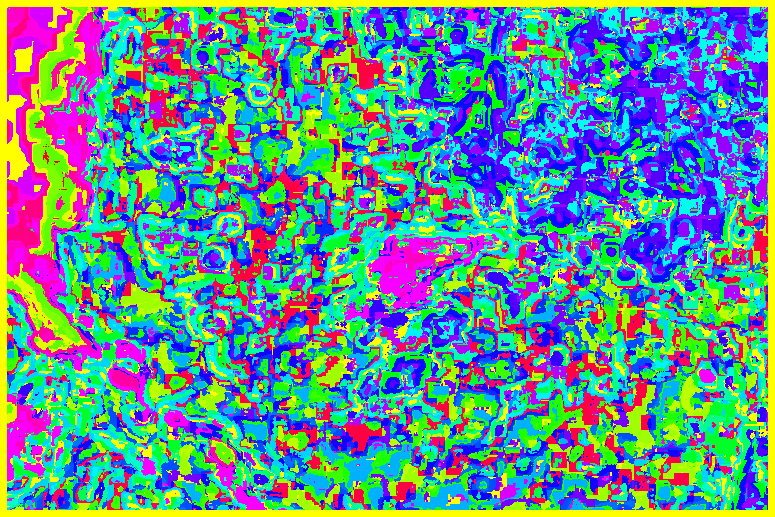

In [22]:
grs.rast.RasterRow('gng.textures.40')

Получившийся граф (не все ребра, а только 75% наиболее свежих связей):

<img src="Img/Textures/textures.gng.40.png" >

Зональная статистика по результату кластеризаци (по растру вырубки):

In [23]:
print grs.grass.read_command('r.report', map='train15_16,gng.textures.40', units='p')

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: FOREST                                     Tue Jul 19 12:44:45 2016|
|-----------------------------------------------------------------------------|
|          north:    5274431    east: 520958                                  |
|REGION    south:    5272881    west: 518633                                  |
|          res:   2.99806576    res:       3                                  |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAPS: Rasterized vector map from values (train15_16 in exploration)          |
|        (untitled) (gng.textures.40 in exploration)                          |
|---------------------------------------

In [24]:
nx.write_graphml(g, 'textures.graphml')